In [1]:
################################################################################
######################   UsedCarPrices_CarGurus  ###############################
######################   Regression - Nonlinear  ###############################
######################     Xgboost HPO GPU       ###############################
################################################################################

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install xgboost==1.5.2
!pip install optuna
!pip install eli5
!pip install shap
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
import joblib
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
import optuna
from optuna import Trial
optuna.logging.set_verbosity(optuna.logging.WARNING) 
from datetime import datetime, timedelta
from timeit import default_timer as timer
import pickle
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import plotly.offline as py
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import eli5 as eli
from eli5.sklearn import PermutationImportance 
from eli5 import show_weights
import webbrowser
from eli5.sklearn import explain_weights_sklearn
from eli5.formatters import format_as_dataframe, format_as_dataframes
import shap 

my_dpi=96

!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 173.6 MB 7.1 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 4.1 MB/s 
     |████████████████████████████████| 81 kB 11.2 MB/s 
     |████████████████████████████████| 210 kB 82.9 MB/s 
     |████████████████████████████████| 78 kB 8.7 MB/s 
     |████████████████████████████████| 146 kB 95.0 MB/s 
     |████████████████████████████████| 112 kB 77.5 MB/s 
     |████████████████████████████████| 49 kB 7.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=5d4bcf23e38ae074150453e6b6629324b369f9f5e98d31f0977a60255862c8b8
  Stored in directory: /root/.cach

In [4]:
%cd /content/drive/MyDrive/UsedCarsCarGurus/Data/

/content/drive/MyDrive/UsedCarsCarGurus/Data


In [5]:
# Set seed 
seed_value = 42
os.environ['UsedCarsCarGurus_XgboostGPU'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [6]:
# Read data
df = pd.read_csv('usedCars_final.csv', low_memory=False)

In [7]:
# Prepare for partitioning data
X = df.drop(['price'],axis=1)
y = df['price']

In [8]:
# Set up train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state = seed_value)

In [9]:
train = pd.concat([y_train, X_train], axis=1)

train = pd.get_dummies(train, drop_first=True)

In [10]:
# Define label and features
label = train[['price']]

# Remove target
features = train.drop(columns = ['price'])

# Extract feature names
feature_names = list(features.columns)

features = features.columns

features = np.array(features)

In [11]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/Xgboost/Optuna/Model_PKL

/content/drive/MyDrive/UsedCarsCarGurus/ML/Xgboost/Optuna/Model_PKL


In [12]:
################################################################################
######################     Xgboost Optuna HPO   ################################
######################        100 trials        ################################
################################################################################
# Define a function for optimization of hyperparameters
def objective(trial):
    '''
    Objective function to tune a `XgboostRegressor` model.
    '''
    joblib.dump(study, 'Xgboost_Optuna_100_GPU.pkl')

    # Define parameter grid
    params_xgboost_optuna = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_uniform('subsample', 0.25, 0.75),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.3),
        'reg_alpha' : trial.suggest_loguniform('reg_alpha', 1e-8, 30),
        'reg_lambda' : trial.suggest_loguniform('reg_lambda', 1e-8, 3),
        'colsample_bytree' : trial.suggest_uniform('colsample_bytree', 0.5, 1),
        'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel', 0.05, 0.5), 
        'min_child_weight' : trial.suggest_int('min_child_weight', 0, 10),
    }

    kf = KFold(n_splits=10, shuffle=True, random_state=seed_value)
    for trn_idx, val_idx in kf.split(train[features], label): 
      train_features, train_label = train[features].iloc[trn_idx], label.iloc[trn_idx]
      # Validation data for the fold
      val_features, val_label = train[features].iloc[val_idx], label.iloc[val_idx] 
                                                                          
      # Start timer for each trial
      start = timer()

      # Define model type   
      model = XGBRegressor(
          objective='reg:squarederror',
          n_jobs=-1,
          random_state=seed_value,
          booster='gbtree', 
          tree_method='gpu_hist',    
          scale_pos_weight=1,
          use_label_encoder=False,
          verbosity=0,
          **params_xgboost_optuna
    )
      # Train the model
      model.fit(train_features, train_label, 
                eval_set = [(val_features, val_label), 
                            (train_features, train_label)]) 
        
      # Predictions
      y_pred_val = model.predict(val_features)

      rmse = mean_squared_error(val_label, y_pred_val,squared=False)
        
      run_time = timer() - start

      return rmse     

In [13]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
if os.path.isfile('Xgboost_Optuna_100_GPU.pkl'):
    study = joblib.load('Xgboost_Optuna_100_GPU.pkl')
else:
    study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest RMSE', study.best_value)

Streaming output truncated to the last 5000 lines.
[443]	validation_0-rmse:2458.60132	validation_1-rmse:1483.10303
[444]	validation_0-rmse:2458.41431	validation_1-rmse:1481.90930
[445]	validation_0-rmse:2458.66846	validation_1-rmse:1480.40649
[446]	validation_0-rmse:2458.29858	validation_1-rmse:1479.25940
[447]	validation_0-rmse:2458.28394	validation_1-rmse:1478.04553
[448]	validation_0-rmse:2458.09448	validation_1-rmse:1476.20862
[449]	validation_0-rmse:2458.19385	validation_1-rmse:1474.71606
[450]	validation_0-rmse:2458.28882	validation_1-rmse:1473.56665
[451]	validation_0-rmse:2458.45337	validation_1-rmse:1472.39563
[452]	validation_0-rmse:2458.77026	validation_1-rmse:1470.47742
[453]	validation_0-rmse:2458.71143	validation_1-rmse:1469.07190
[454]	validation_0-rmse:2458.94360	validation_1-rmse:1467.60132
[455]	validation_0-rmse:2458.85742	validation_1-rmse:1466.82324
[456]	validation_0-rmse:2458.99072	validation_1-rmse:1465.38184
[457]	validation_0-rmse:2458.72974	validation_1-rmse:

In [14]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/Xgboost/Optuna/trialOptions/

/content/drive/MyDrive/UsedCarsCarGurus/ML/Xgboost/Optuna/trialOptions


In [15]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'rmse'},inplace=True)
trials_df.rename(columns={'params_colsample_bylevel':'colsample_bylevel'}, inplace=True)
trials_df.rename(columns={'params_colsample_bytree':'colsample_bytree'}, inplace=True)
trials_df.rename(columns={'params_gamma':'gamma'}, inplace=True)
trials_df.rename(columns={'params_learning_rate':'learning_rate'}, inplace=True)
trials_df.rename(columns={'params_max_depth':'max_depth'}, inplace=True)
trials_df.rename(columns={'params_min_child_weight':'min_child_weight'}, inplace=True)
trials_df.rename(columns={'params_n_estimators':'n_estimators'}, inplace=True)
trials_df.rename(columns={'params_reg_alpha':'reg_alpha'}, inplace=True)
trials_df.rename(columns={'params_reg_lambda':'reg_lambda'}, inplace=True)
trials_df.rename(columns={'params_subsample':'subsample'}, inplace=True)
trials_df = trials_df.sort_values('rmse', ascending=True)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('Xgboost_Optuna_100_GPU.csv', index=False)

    iteration          rmse             datetime_start  \
77         77   2400.272568 2022-05-27 01:57:03.934040   
93         93   2402.703276 2022-05-27 02:01:50.174404   
72         72   2403.342355 2022-05-27 01:55:46.650726   
81         81   2407.690191 2022-05-27 01:58:30.605404   
71         71   2408.105323 2022-05-27 01:55:27.112495   
..        ...           ...                        ...   
17         17  16155.038485 2022-05-27 01:46:17.985295   
57         57  24787.408288 2022-05-27 01:51:11.657933   
9           9  25484.469682 2022-05-27 01:45:17.706532   
3           3  27304.628719 2022-05-27 01:44:22.476510   
26         26  29111.544427 2022-05-27 01:47:27.925023   

            datetime_complete               duration  colsample_bylevel  \
77 2022-05-27 01:57:23.877284 0 days 00:00:19.943244           0.384103   
93 2022-05-27 02:02:11.233016 0 days 00:00:21.058612           0.360861   
72 2022-05-27 01:56:06.052813 0 days 00:00:19.402087           0.433460   
81 

In [16]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/Xgboost/Optuna/Model_Explanations/

/content/drive/MyDrive/UsedCarsCarGurus/ML/Xgboost/Optuna/Model_Explanations


In [17]:
# Plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_Xgboost_Optuna_100_GPU.html')
fig.show()

In [18]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_Xgboost_Optuna_100_GPU.html')
fig.show()

In [19]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_Xgboost_Optuna_100_GPU.html')
fig.show()

In [20]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/Xgboost/Optuna/Model_PKL/

study = joblib.load('Xgboost_Optuna_100_GPU.pkl')

/content/drive/MyDrive/UsedCarsCarGurus/ML/Xgboost/Optuna/Model_PKL


In [21]:
# plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.

fig = optuna.visualization.plot_contour(study, params=['min_child_weight', 
                                                       'max_depth', 
                                                       'learning_rate', 
                                                       'gamma'])
py.plot(fig, filename='contour_Catboost_Optuna_100_GPU.html')
fig.show()

In [22]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/Xgboost/Optuna/trialOptions/

# Access results
trials_df = pd.read_csv('Xgboost_Optuna_100_GPU.csv')

/content/drive/MyDrive/UsedCarsCarGurus/ML/Xgboost/Optuna/trialOptions


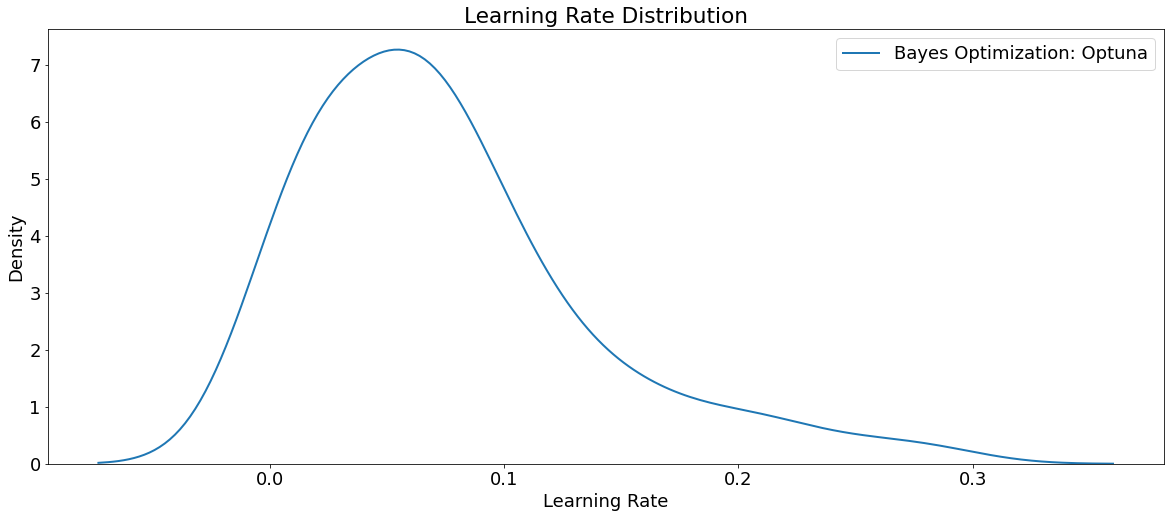

In [23]:
# Density plots of the learning rate distributions 
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18
sns.kdeplot(trials_df['learning_rate'], label = 'Bayes Optimization: Optuna', 
            linewidth = 2)
plt.legend(loc = 1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

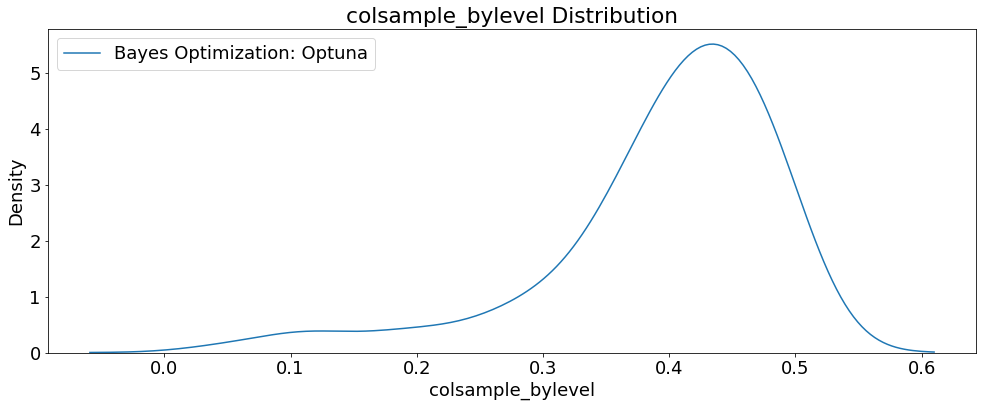

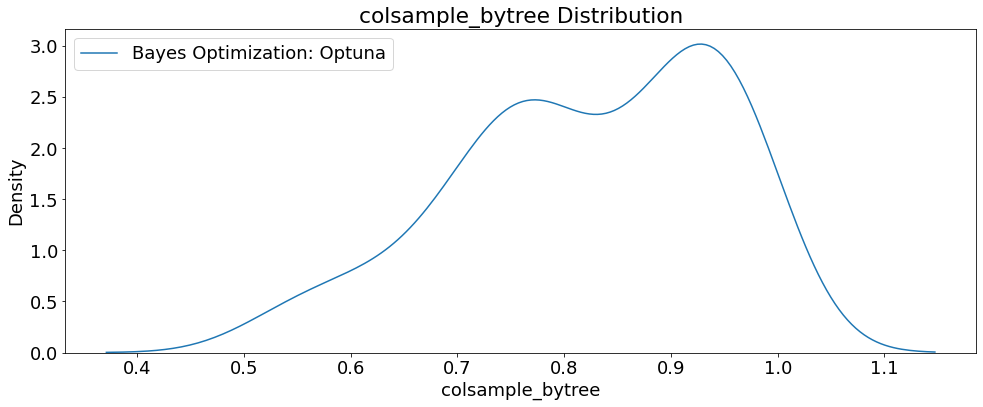

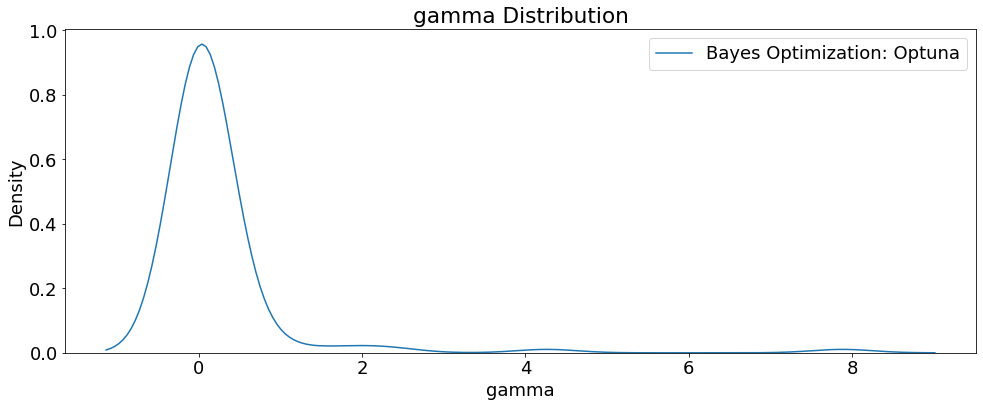

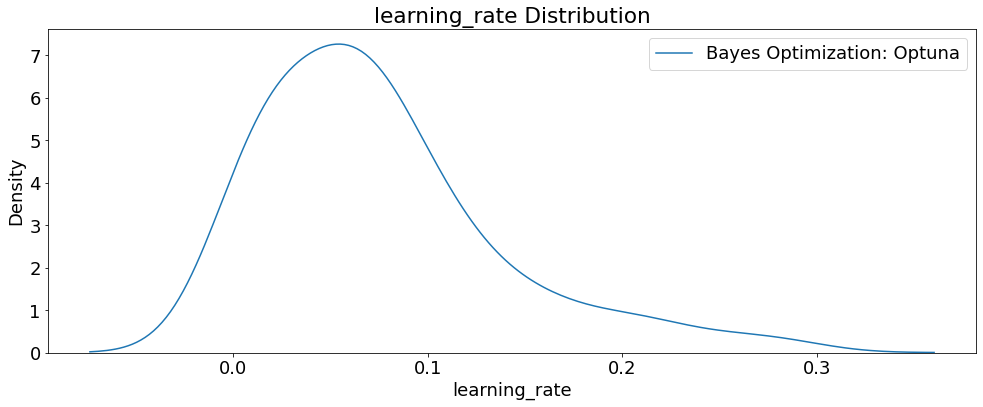

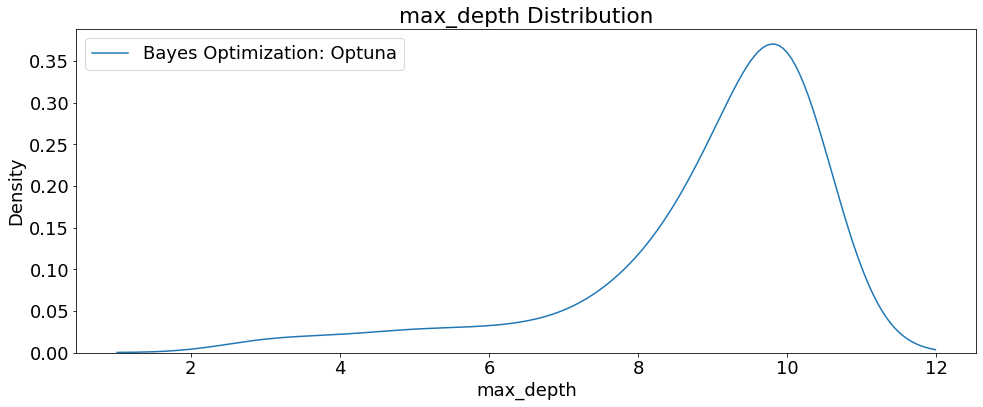

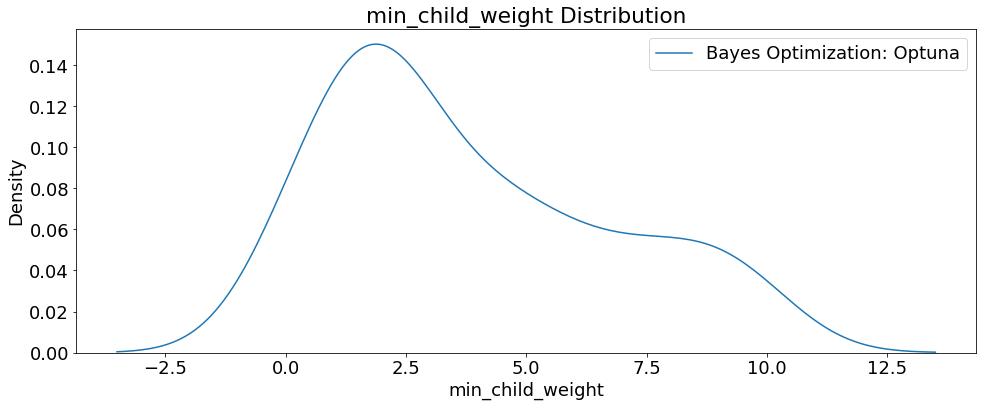

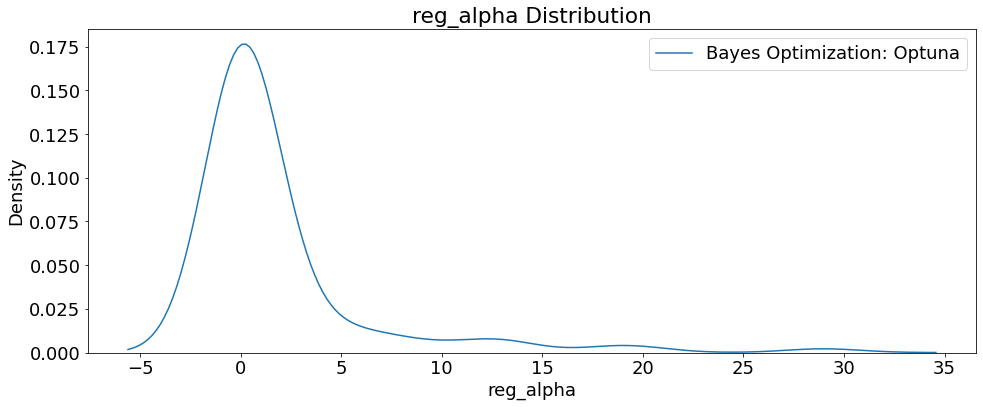

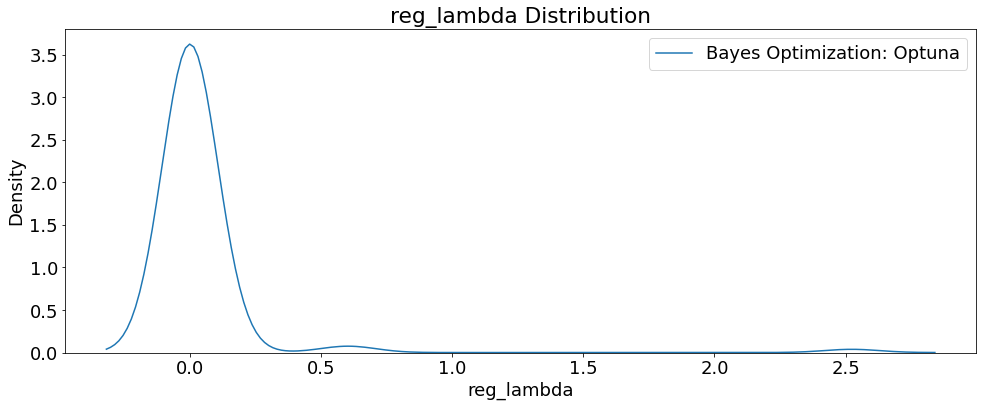

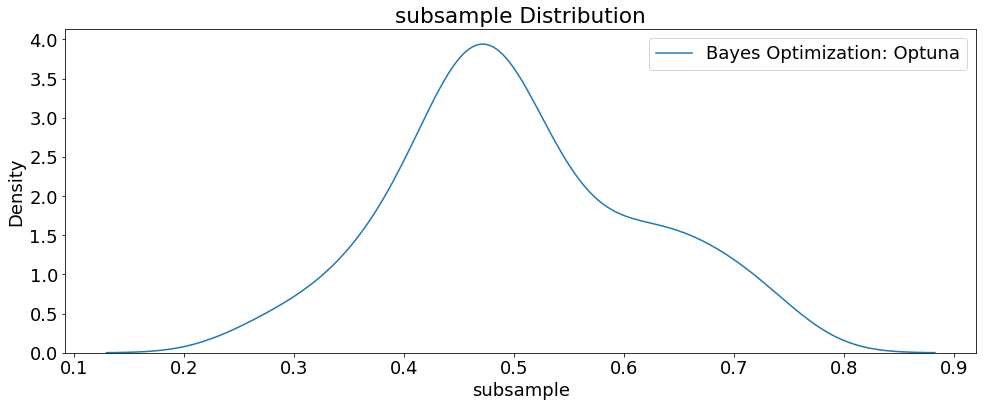

In [24]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'rmse', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label = 'Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


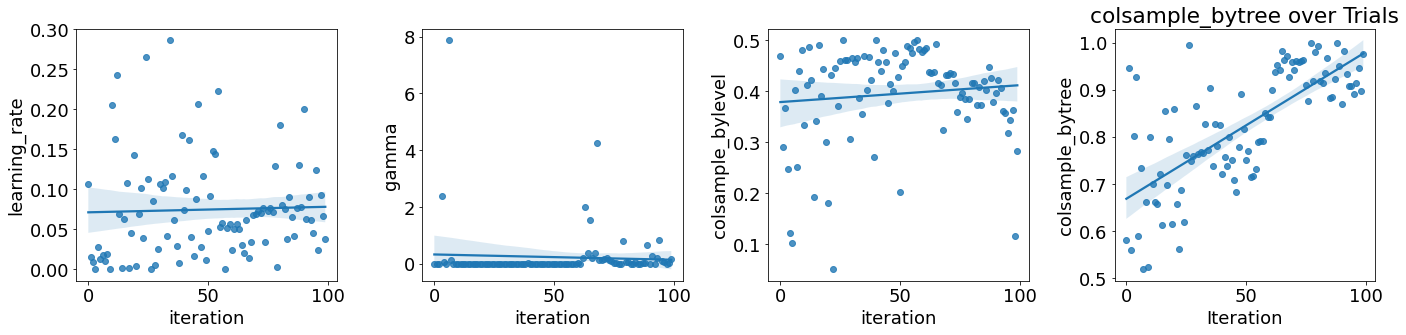

In [25]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize = (20, 5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['learning_rate', 'gamma', 'colsample_bylevel',
                         'colsample_bytree']): 

                        # Scatterplot
                         sns.regplot('iteration', hpo, data = trials_df, ax = axs[i]) 
axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo),  
                                    title = '{} over Trials'.format(hpo))

plt.tight_layout()
plt.show()


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


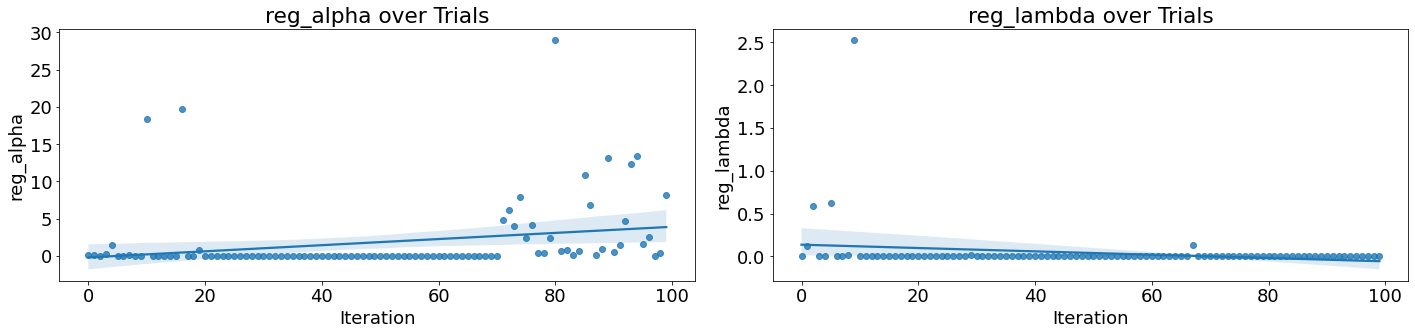

In [26]:
# Scatterplot of regularization hyperparameters)
fig, axs = plt.subplots(1, 2, figsize = (20, 5))
i = 0
for i, hpo in enumerate(['reg_alpha', 'reg_lambda']):
        # Scatterplot
        sns.regplot('iteration', hpo, data = trials_df, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo), 
                   title = '{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [27]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/Xgboost/Optuna/Model_PKL/

study = joblib.load('Xgboost_Optuna_100_GPU.pkl')

/content/drive/MyDrive/UsedCarsCarGurus/ML/Xgboost/Optuna/Model_PKL


In [28]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/Xgboost/Optuna/Model_Explanations/

/content/drive/MyDrive/UsedCarsCarGurus/ML/Xgboost/Optuna/Model_Explanations


In [29]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_Xgboost_Optuna_100_GPU.html')
fig.show()

In [30]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_Xgboost_Optuna_100_GPU.html')
fig.show()

In [31]:
# Arrange best parameters to fit model for model metrics
params=study.best_params   
params['random_state'] = seed_value
params['metric'] = 'rmse'
params

{'colsample_bylevel': 0.384103204519109,
 'colsample_bytree': 0.9992947156643388,
 'gamma': 0.011668312453734078,
 'learning_rate': 0.07139701835151745,
 'max_depth': 10,
 'metric': 'rmse',
 'min_child_weight': 0,
 'n_estimators': 452,
 'random_state': 42,
 'reg_alpha': 0.3690065895041845,
 'reg_lambda': 7.546778406258371e-08,
 'subsample': 0.4858711876657668}

In [32]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/Xgboost/Optuna/Model_PKL/

/content/drive/MyDrive/UsedCarsCarGurus/ML/Xgboost/Optuna/Model_PKL


In [33]:
# Set up label and features
label = df[['price']]
features = df.drop(['price'],axis=1)

In [34]:
# Prepare for partitioning data
X = df.drop(['price'],axis=1)
y = df['price']

In [35]:
# Set up train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state = seed_value)

In [36]:
# Define label and features
train_label = y_train

# Remove target
train_features = pd.get_dummies(X_train, drop_first=True)

In [37]:
# Re-create the best model and train on the training data
best_model = xgb.XGBRegressor(objective='reg:squarederror', 
                                    booster='gbtree',
                                    tree_method='gpu_hist', 
                                    scale_pos_weight=1,
                                    use_label_encoder=False,
                                    verbosity=0, 
                                    n_jobs=-1,
                                    **params)

# Fit the model
best_model.fit(train_features, train_label)

# Save model
Pkl_Filename = 'Xgboost_Optuna_trials100_GPU.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Xgboost_Optuna_trials100_GPU.pkl')
# print(model)
# =============================================================================

In [38]:
# Create test features
test_features = pd.get_dummies(X_test, drop_first=True)

In [39]:
print('\nModel Metrics for Xgboost HPO 100 GPU trials')
y_train_pred = best_model.predict(train_features)
y_test_pred = best_model.predict(test_features)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred)))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test, y_test_pred, squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))



Model Metrics for Xgboost HPO 100 GPU trials
MAE train: 1359.626, test: 1741.147
MSE train: 3310457.478, test: 5640451.038
RMSE train: 1819.466, test: 2374.963
R^2 train: 0.964, test: 0.938


In [40]:
# Evaluate on the testing data 
print('The best model from optimization scores {:.5f} MSE on the test set.'.format(mean_squared_error(y_test, y_test_pred)))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from optimization scores 5640451.03783 MSE on the test set.
This was achieved using these conditions:
iteration                                    77
rmse                                2400.272568
datetime_start       2022-05-27 01:57:03.934040
datetime_complete    2022-05-27 01:57:23.877284
duration                 0 days 00:00:19.943244
colsample_bylevel                      0.384103
colsample_bytree                       0.999295
gamma                                  0.011668
learning_rate                          0.071397
max_depth                                    10
min_child_weight                              0
n_estimators                                452
reg_alpha                              0.369007
reg_lambda                                  0.0
subsample                              0.485871
state                                  COMPLETE
Name: 0, dtype: object


In [41]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/Xgboost/Optuna/Model_Explanations/

/content/drive/MyDrive/UsedCarsCarGurus/ML/Xgboost/Optuna/Model_Explanations


In [42]:
# Prepare data for SHAP values
train = train_features

In [43]:
# Training Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 432x288 with 0 Axes>

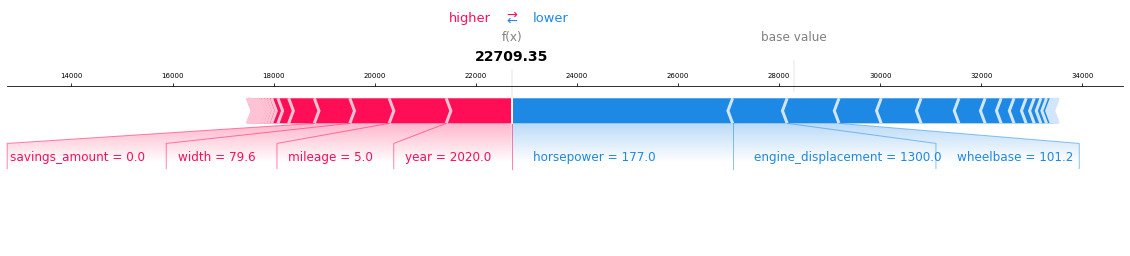

In [44]:
# Visualize the first prediction's explanation
my_dpi=96
fig = plt.figure()
plt.rcParams.update({'font.size': 7})
shap.force_plot(explainer.expected_value, shap_values[0,:], train.iloc[0,:], 
                show=False, matplotlib=True).savefig('Xgboost_HPO_Optuna_100_GPU_ShapForcePlot_TrainSet.png', 
                                                     dpi=my_dpi, bbox_inches='tight')

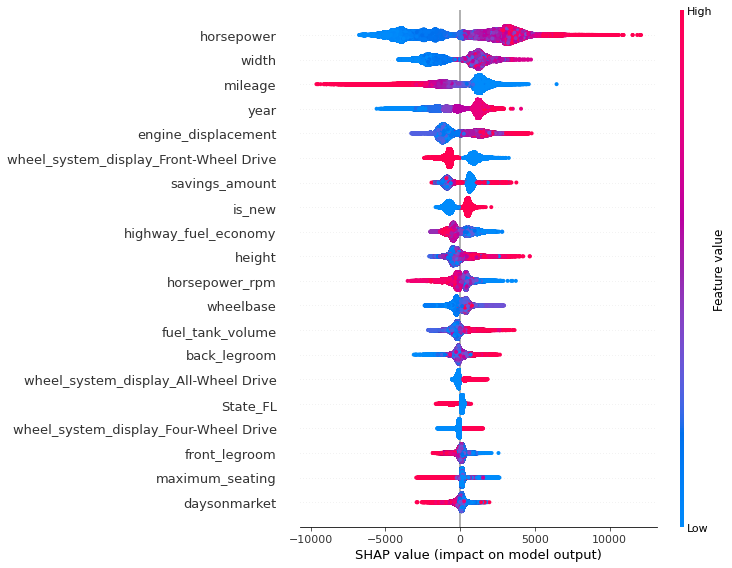

In [45]:
# Training Set: Summarize the effects of all the features
fig = plt.figure()
plt.rcParams.update({'font.size': 7})
shap.summary_plot(shap_values, train, show=False)
fig.savefig('Xgboost_HPO_Optuna_100_GPU_ShapSummary_TrainSet.png', dpi=my_dpi, 
            bbox_inches='tight')

In [46]:
# Test Set: Feature Importance Computed with SHAP Values
shap.initjs()
shap_values = explainer.shap_values(test_features)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 432x288 with 0 Axes>

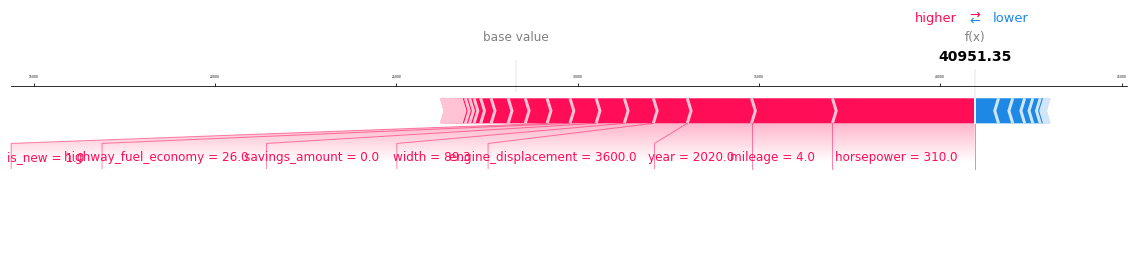

In [47]:
# Visualize the first prediction's explanation
fig = plt.figure()
plt.rcParams.update({'font.size': 3})
shap.force_plot(explainer.expected_value, shap_values[0,:], test_features.iloc[0,:], 
                show=False, matplotlib=True).savefig('Xgboost_HPO_Optuna_100_GPU_ShapForcePlot_TestSet.png', 
                                                     dpi=my_dpi, bbox_inches='tight')

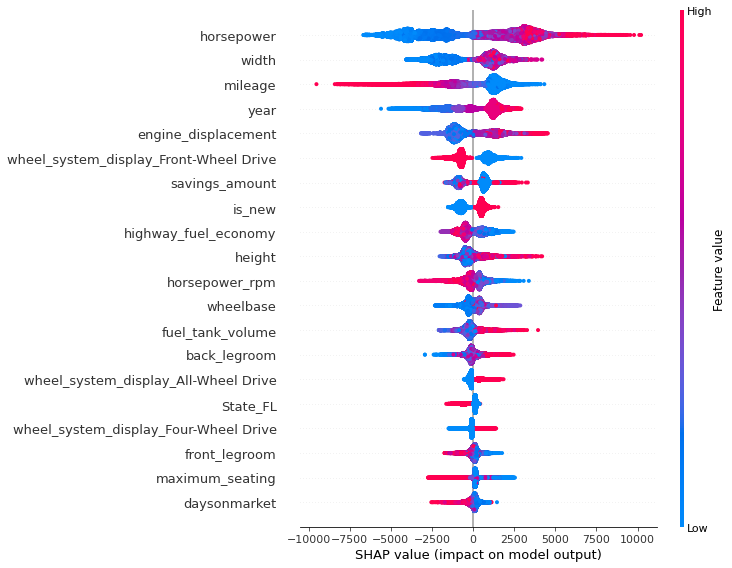

In [48]:
# Test Set: Summarize the effects of all the features
fig = plt.figure()
plt.rcParams.update({'font.size': 7})
shap.summary_plot(shap_values, test_features, show=False)
fig.savefig('Xgboost_HPO_Optuna_100_GPU_ShapSummary_TestSet.png', dpi=my_dpi, 
            bbox_inches='tight')

In [49]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_model,
                                        random_state=seed_value).fit(test_features,
                                                                     y_test)

In [50]:
# Get the weights
X_test1 = pd.DataFrame(test_features, columns=test_features.columns)                                                                    

# Store feature weights in an object
html_obj = eli.show_weights(perm_importance,
                            feature_names = X_test1.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/UsedCarsCarGurus/ML/Xgboost/Optuna/Model_Explanations/best_bayes_Optuna_100_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode("UTF-8"))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/UsedCarsCarGurus/ML/Xgboost/Optuna/Model_Explanations/best_bayes_Optuna_100_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

Weight,Feature
0.3177 ± 0.0030,horsepower
0.0871 ± 0.0012,year
0.0803 ± 0.0018,mileage
0.0741 ± 0.0008,width
0.0666 ± 0.0007,engine_displacement
0.0505 ± 0.0003,height
0.0268 ± 0.0003,highway_fuel_economy
0.0264 ± 0.0002,wheel_system_display_Front-Wheel Drive
0.0259 ± 0.0004,fuel_tank_volume
0.0251 ± 0.0002,back_legroom


In [51]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/Xgboost/Optuna/bestBayes_WeightsExplain/

/content/drive/MyDrive/UsedCarsCarGurus/ML/Xgboost/Optuna/bestBayes_WeightsExplain


In [52]:
# Explain weights
explanation = eli.explain_weights_sklearn(perm_importance,
                            feature_names = X_test1.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_Optuna_100_GPU_WeightsExplain.csv',
           index=False, encoding='utf-8-sig')

exp

,feature,weight,std
0,horsepower,0.317729,0.001511
1,year,0.087147,0.000600
2,mileage,0.080309,0.000917
3,width,0.074057,0.000405
4,engine_displacement,0.066576,0.000365
5,height,0.050527,0.000158
6,highway_fuel_economy,0.026801,0.000159
7,wheel_system_display_Front-Wheel Drive,0.026407,0.000121
8,fuel_tank_volume,0.025902,0.000218
9,back_legroom,0.025066,0.000113
